## **Code Solution for Question-1 on Physics informed neural networks starts from here**

Training data shape: torch.Size([30, 2])
Test data shape: torch.Size([10000, 2])
Training Model 1: Data-driven Neural Network...
Epoch 1000/5000, Loss: 0.000163
Epoch 2000/5000, Loss: 0.000093
Epoch 3000/5000, Loss: 0.000073
Epoch 4000/5000, Loss: 0.000060
Epoch 5000/5000, Loss: 0.000048

Training Model 2: Physics-Informed Neural Network...
Epoch 1000/5000, Loss: 0.004255
Epoch 2000/5000, Loss: 0.001895
Epoch 3000/5000, Loss: 0.001419
Epoch 4000/5000, Loss: 0.001113
Epoch 5000/5000, Loss: 0.000690

Model 1 (Data-driven) - RMSE: 0.0326, MAE: 0.0195
Model 2 (PINN) - RMSE: 0.0315, MAE: 0.0159
Linear Interpolation - RMSE: 0.3025, MAE: 0.1548


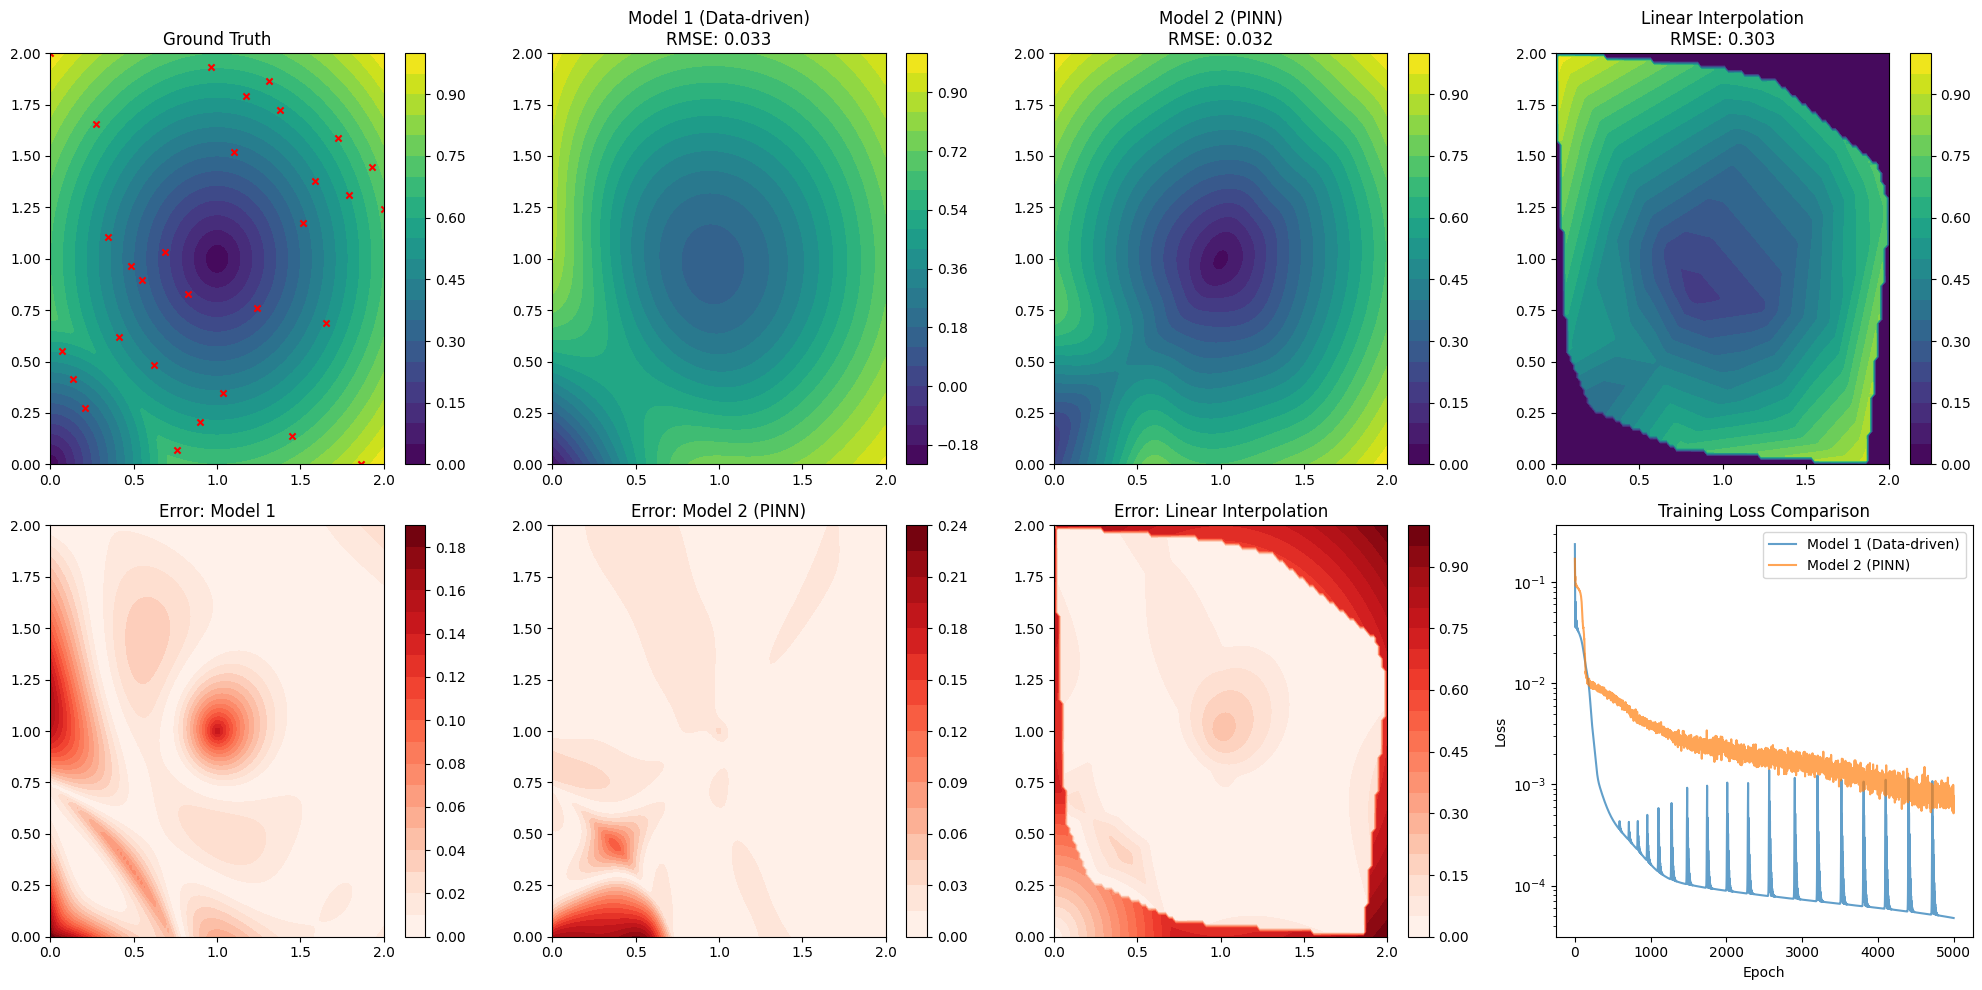


ASSIGNMENT 1 RESULTS SUMMARY
Training samples: 30
Test samples: 10000

Performance Comparison:
Method               RMSE       MAE       
----------------------------------------
Data-driven NN       0.0326     0.0195    
PINN                 0.0315     0.0159    
Linear Interpolation 0.3025     0.1548    


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from scipy.interpolate import griddata

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# ---------------------------
# Part A: Data Generation and Setup
# ---------------------------
def generate_synthetic_data(nx=100, ny=100):
    """Generate synthetic cardiac activation time data"""
    x = np.linspace(0, 2, nx)
    y = np.linspace(0, 2, ny)
    X, Y = np.meshgrid(x, y)
    # T(x,y) = min(sqrt(x^2 + y^2), 0.7 * sqrt((x-1)^2 + (y-1)^2))
    dist1 = np.sqrt(X**2 + Y**2)
    dist2 = 0.7 * np.sqrt((X - 1)**2 + (Y - 1)**2)
    T = np.minimum(dist1, dist2)
    return X, Y, T

def conduction_velocity(x, y):
    """Define conduction velocity V(x, y)
       Returns 1.0 if sqrt(x^2 + y^2) < 0.7*sqrt((x-1)^2+(y-1)^2)
       otherwise returns 1.0/0.7"""
    dist1 = np.sqrt(x**2 + y**2)
    dist2 = 0.7 * np.sqrt((x - 1)**2 + (y - 1)**2)
    # Use a simple conditional to return a scalar float value.
    return 1.0 if dist1 < dist2 else 1.0/0.7

def latin_hypercube_sampling(n_samples, bounds):
    """Generate Latin Hypercube samples in a given set of bounds"""
    n_dim = len(bounds)
    samples = np.zeros((n_samples, n_dim))
    for i in range(n_dim):
        low, high = bounds[i]
        # Generate n_samples evenly distributed numbers and shuffle them
        values = np.linspace(0, 1, n_samples)
        np.random.shuffle(values)
        samples[:, i] = low + (high - low) * values
    return samples

# Generate full dataset
X_full, Y_full, T_full = generate_synthetic_data()
x_test = np.column_stack([X_full.flatten(), Y_full.flatten()])
t_test = T_full.flatten()

# Generate sparse training data using Latin Hypercube Sampling
n_train = 30
bounds = [(0, 2), (0, 2)]
x_train_sparse = latin_hypercube_sampling(n_train, bounds)

# Calculate true activation times for training points
t_train_sparse = []
for point in x_train_sparse:
    x, y = point
    # Corrected: use x**2 and y**2 instead of x2 and y2
    dist1 = np.sqrt(x**2 + y**2)
    dist2 = 0.7 * np.sqrt((x - 1)**2 + (y - 1)**2)
    t_train_sparse.append(min(dist1, dist2))
t_train_sparse = np.array(t_train_sparse)

# Convert to PyTorch tensors
x_train_tensor = torch.FloatTensor(x_train_sparse)
t_train_tensor = torch.FloatTensor(t_train_sparse).reshape(-1, 1)
x_test_tensor = torch.FloatTensor(x_test)
t_test_tensor = torch.FloatTensor(t_test).reshape(-1, 1)

print(f"Training data shape: {x_train_tensor.shape}")
print(f"Test data shape: {x_test_tensor.shape}")

# ---------------------------
# Part B: Neural Network Models
# ---------------------------
class FeedforwardNN(nn.Module):
    """Standard feedforward neural network"""
    def __init__(self, input_dim=2, hidden_dims=[50, 50, 50], output_dim=1):
        super(FeedforwardNN, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.Tanh()
            ])
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class PINN(nn.Module):
    """Physics-Informed Neural Network"""
    def __init__(self, input_dim=2, hidden_dims=[50, 50, 50], output_dim=1):
        super(PINN, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.Tanh()
            ])
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def compute_physics_loss(model, x):
    """Compute physics-informed loss using the Eikonal equation"""
    x.requires_grad_(True)
    t_pred = model(x)
    gradients = torch.autograd.grad(
        outputs=t_pred,
        inputs=x,
        grad_outputs=torch.ones_like(t_pred),
        create_graph=True,
        retain_graph=True
    )[0]

    dt_dx = gradients[:, 0:1]
    dt_dy = gradients[:, 1:2]
    grad_magnitude = torch.sqrt(dt_dx**2 + dt_dy**2)

    # Compute conduction velocity at each point using the corrected function
    x_np = x.detach().numpy()
    v_values = []
    for i in range(x.shape[0]):
        v = conduction_velocity(x_np[i, 0], x_np[i, 1])
        v_values.append(v)
    v_tensor = torch.FloatTensor(v_values).reshape(-1, 1)

    # Eikonal residual: V(x,y)*||∇T(x,y)|| - 1
    residual = v_tensor * grad_magnitude - 1.0
    return torch.mean(residual**2)

def train_model(model, x_train, t_train, is_pinn=False, epochs=5000, lr=0.001):
    """Train neural network model"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Data loss
        t_pred = model(x_train)
        data_loss = torch.mean((t_pred - t_train)**2)
        total_loss = data_loss

        if is_pinn:
            # Generate collocation points for physics loss
            n_colloc = 1000
            x_colloc = torch.FloatTensor(np.random.uniform(0, 2, (n_colloc, 2)))
            physics_loss = compute_physics_loss(model, x_colloc)
            total_loss = data_loss + 0.1 * physics_loss  # weight of physics loss

        total_loss.backward()
        optimizer.step()
        losses.append(total_loss.item())

        if (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss.item():.6f}")
    return losses

print("Training Model 1: Data-driven Neural Network...")
model1 = FeedforwardNN()
losses1 = train_model(model1, x_train_tensor, t_train_tensor, is_pinn=False)

print("\nTraining Model 2: Physics-Informed Neural Network...")
model2 = PINN()
losses2 = train_model(model2, x_train_tensor, t_train_tensor, is_pinn=True)

# ---------------------------
# Part C: Comparison and Visualization
# ---------------------------
def evaluate_model(model, x_test, t_test):
    """Evaluate model performance and compute RMSE and MAE"""
    model.eval()
    with torch.no_grad():
        t_pred = model(x_test)
        rmse = torch.sqrt(torch.mean((t_pred - t_test)**2)).item()
        mae = torch.mean(torch.abs(t_pred - t_test)).item()
    return t_pred.numpy(), rmse, mae

t_pred1, rmse1, mae1 = evaluate_model(model1, x_test_tensor, t_test_tensor)
t_pred2, rmse2, mae2 = evaluate_model(model2, x_test_tensor, t_test_tensor)

print(f"\nModel 1 (Data-driven) - RMSE: {rmse1:.4f}, MAE: {mae1:.4f}")
print(f"Model 2 (PINN) - RMSE: {rmse2:.4f}, MAE: {mae2:.4f}")

# Linear interpolation baseline
def linear_interpolation_baseline(x_train, t_train, x_test):
    """Linear interpolation baseline using scipy.griddata"""
    t_interp = griddata(x_train, t_train.flatten(), x_test, method='linear', fill_value=0)
    return t_interp

t_pred_interp = linear_interpolation_baseline(x_train_sparse, t_train_sparse, x_test)
rmse_interp = np.sqrt(np.mean((t_pred_interp - t_test)**2))
mae_interp = np.mean(np.abs(t_pred_interp - t_test))
print(f"Linear Interpolation - RMSE: {rmse_interp:.4f}, MAE: {mae_interp:.4f}")

# Visualization
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
nx, ny = 100, 100
t_true_plot = T_full
t_pred1_plot = t_pred1.reshape(nx, ny)
t_pred2_plot = t_pred2.reshape(nx, ny)
t_interp_plot = t_pred_interp.reshape(nx, ny)

# Compute error maps
error1 = np.abs(t_true_plot - t_pred1_plot)
error2 = np.abs(t_true_plot - t_pred2_plot)
error_interp = np.abs(t_true_plot - t_interp_plot)

# Plot activation maps
im1 = axes[0, 0].contourf(X_full, Y_full, t_true_plot, levels=20, cmap='viridis')
axes[0, 0].set_title('Ground Truth')
axes[0, 0].scatter(x_train_sparse[:, 0], x_train_sparse[:, 1], c='red', s=20, marker='x')
plt.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].contourf(X_full, Y_full, t_pred1_plot, levels=20, cmap='viridis')
axes[0, 1].set_title(f'Model 1 (Data-driven)\nRMSE: {rmse1:.3f}')
plt.colorbar(im2, ax=axes[0, 1])

im3 = axes[0, 2].contourf(X_full, Y_full, t_pred2_plot, levels=20, cmap='viridis')
axes[0, 2].set_title(f'Model 2 (PINN)\nRMSE: {rmse2:.3f}')
plt.colorbar(im3, ax=axes[0, 2])

im4 = axes[0, 3].contourf(X_full, Y_full, t_interp_plot, levels=20, cmap='viridis')
axes[0, 3].set_title(f'Linear Interpolation\nRMSE: {rmse_interp:.3f}')
plt.colorbar(im4, ax=axes[0, 3])

# Plot error maps
im5 = axes[1, 0].contourf(X_full, Y_full, error1, levels=20, cmap='Reds')
axes[1, 0].set_title('Error: Model 1')
plt.colorbar(im5, ax=axes[1, 0])

im6 = axes[1, 1].contourf(X_full, Y_full, error2, levels=20, cmap='Reds')
axes[1, 1].set_title('Error: Model 2 (PINN)')
plt.colorbar(im6, ax=axes[1, 1])

im7 = axes[1, 2].contourf(X_full, Y_full, error_interp, levels=20, cmap='Reds')
axes[1, 2].set_title('Error: Linear Interpolation')
plt.colorbar(im7, ax=axes[1, 2])

# Training loss comparison
axes[1, 3].plot(losses1, label='Model 1 (Data-driven)', alpha=0.7)
axes[1, 3].plot(losses2, label='Model 2 (PINN)', alpha=0.7)
axes[1, 3].set_xlabel('Epoch')
axes[1, 3].set_ylabel('Loss')
axes[1, 3].set_title('Training Loss Comparison')
axes[1, 3].legend()
axes[1, 3].set_yscale('log')

plt.tight_layout()
plt.show()

# Summary results
print("\n" + "="*50)
print("ASSIGNMENT 1 RESULTS SUMMARY")
print("="*50)
print(f"Training samples: {n_train}")
print(f"Test samples: {len(t_test)}")
print("\nPerformance Comparison:")
print(f"{'Method':<20} {'RMSE':<10} {'MAE':<10}")
print("-" * 40)
print(f"{'Data-driven NN':<20} {rmse1:<10.4f} {mae1:<10.4f}")
print(f"{'PINN':<20} {rmse2:<10.4f} {mae2:<10.4f}")
print(f"{'Linear Interpolation':<20} {rmse_interp:<10.4f} {mae_interp:<10.4f}")
print("="*50)

# Code Solution for question-2 starts form here

In [4]:
!pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Training baseline Fully Connected NN...
Epoch [20/200], Loss: 0.3163
Epoch [40/200], Loss: 0.2574
Epoch [60/200], Loss: 0.2212
Epoch [80/200], Loss: 0.1765
Epoch [100/200], Loss: 0.1375
Epoch [120/200], Loss: 0.1127
Epoch [140/200], Loss: 0.0975
Epoch [160/200], Loss: 0.0858
Epoch [180/200], Loss: 0.0784
Epoch [200/200], Loss: 0.0736
Baseline NN Train Accuracy: 97.12%
Baseline NN Test Accuracy: 98.00%

Training Neural ODE Model...
Epoch [20/200], Loss: 0.2594
Epoch [40/200], Loss: 0.0901
Epoch [60/200], Loss: 0.0652
Epoch [80/200], Loss: 0.0588
Epoch [100/200], Loss: 0.0567
Epoch [120/200], Loss: 0.0538
Epoch [140/200], Loss: 0.0524
Epoch [160/200], Loss: 0.0520
Epoch [180/200], Loss: 0.0510
Epoch [200/200], Loss: 0.0476
Neural ODE Model Train Accuracy: 98.12%
Neural ODE Model Test Accuracy: 98.50%


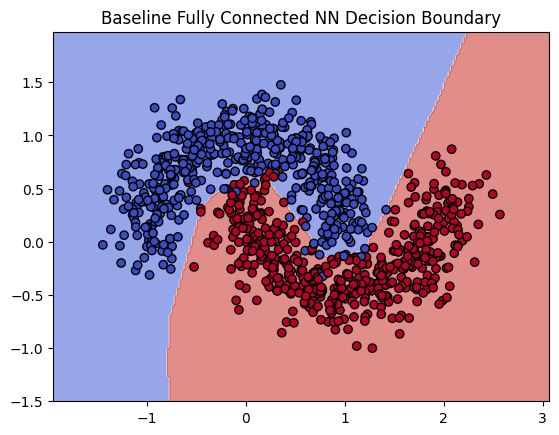

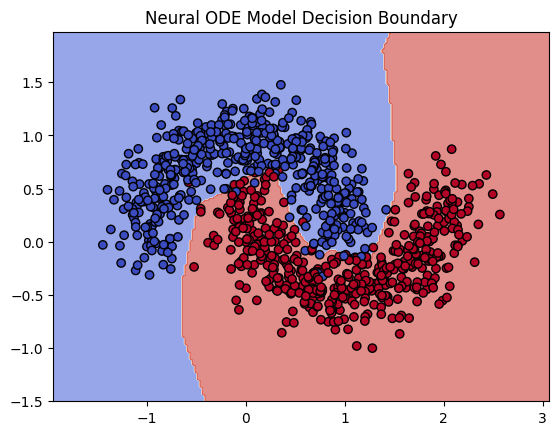


Performance Comparison:
------------------------------
Model                    Train Acc (%)  Test Acc (%)   Final Loss
----------------------------------------------------------------------
Baseline NN              97.12          98.00          0.0526    
Neural ODE               98.12          98.50          0.0409    

Discussion:
The Neural ODE provides a continuous transformation of the hidden state,
which may allow for adaptive computation and smoother transformations compared to
a discrete hidden layer. In our case, the overall classification performance might be
similar, but the evolution dynamics are different. In a discrete network, the hidden state
is updated via a fixed transformation (one hidden layer), while in a Neural ODE, the hidden state
is continuously evolved over time t ∈ [0, 1].

(Optional Bonus) Notice that a residual connection of the form:
   h_next = h + f(h)
is analogous to performing one Euler integration step:
   h(t+Δt) ≈ h(t) + Δt * f(h(t)),
with Δt = 1

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torchdiffeq import odeint  # make sure to install via: pip install torchdiffeq

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

######################################
# Part A: Baseline Fully Connected NN
######################################
# Create a simple 2D toy dataset (two interleaving moons)
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X = X.astype(np.float32)
y = y.astype(np.int64)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

# Define a simple fully connected network with one hidden layer (32 neurons, ReLU)
class FullyConnectedNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32, output_dim=2):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h = self.fc1(x)
        h = self.relu(h)
        out = self.fc2(h)
        return out

######################################
# Part B: Neural ODE Model
######################################
# The Neural ODE block replaces the hidden layer.
# First define the ODE function f(h,t), here implemented as a small neural network.
class ODEFunc(nn.Module):
    def __init__(self, hidden_dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, 16),
            nn.ReLU(),
            nn.Linear(16, hidden_dim),
        )

    def forward(self, t, h):
        return self.net(h)

# Define the Neural ODE block that evolves the hidden state over t ∈ [0, 1]
class NeuralODEBlock(nn.Module):
    def __init__(self, hidden_dim):
        super(NeuralODEBlock, self).__init__()
        self.odefunc = ODEFunc(hidden_dim)

    def forward(self, h):
        # Define time points for integration
        t = torch.tensor([0, 1]).float().to(h.device)
        # The odeint function returns the full trajectory: shape [time, batch, hidden_dim]
        h_out = odeint(self.odefunc, h, t, method='rk4')
        # We take the final state at t=1 for further classification
        return h_out[1]

# Define the Neural ODE model: input -> fc layer (projection) -> Neural ODE block -> classifier (fc layer)
class NeuralODEModel(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32, output_dim=2):
        super(NeuralODEModel, self).__init__()
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.odeblock = NeuralODEBlock(hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h = self.fc_in(x)
        h = self.relu(h)
        h = self.odeblock(h)
        out = self.fc_out(h)
        return out

######################################
# Training and Evaluation Functions
######################################
def train_model(model, X_train, y_train, epochs=200, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        logits = model(X_train)
        loss = criterion(logits, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Print loss every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    return losses

def evaluate_model(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        loss = nn.CrossEntropyLoss()(logits, y)
        predictions = torch.argmax(logits, dim=1)
        accuracy = (predictions == y).float().mean().item()
    return loss.item(), accuracy

######################################
# Train the Baseline Fully Connected NN
######################################
print("Training baseline Fully Connected NN...")
baseline_model = FullyConnectedNN()
baseline_losses = train_model(baseline_model, X_train_tensor, y_train_tensor)

baseline_train_loss, baseline_train_acc = evaluate_model(baseline_model, X_train_tensor, y_train_tensor)
baseline_test_loss, baseline_test_acc = evaluate_model(baseline_model, X_test_tensor, y_test_tensor)
print(f"Baseline NN Train Accuracy: {baseline_train_acc*100:.2f}%")
print(f"Baseline NN Test Accuracy: {baseline_test_acc*100:.2f}%")

######################################
# Train the Neural ODE Model
######################################
print("\nTraining Neural ODE Model...")
neural_ode_model = NeuralODEModel()
ode_losses = train_model(neural_ode_model, X_train_tensor, y_train_tensor)

ode_train_loss, ode_train_acc = evaluate_model(neural_ode_model, X_train_tensor, y_train_tensor)
ode_test_loss, ode_test_acc = evaluate_model(neural_ode_model, X_test_tensor, y_test_tensor)
print(f"Neural ODE Model Train Accuracy: {ode_train_acc*100:.2f}%")
print(f"Neural ODE Model Test Accuracy: {ode_test_acc*100:.2f}%")

######################################
# Visualize Decision Boundaries
######################################
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    model.eval()
    # Create a meshgrid over the input space
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)
    with torch.no_grad():
        logits = model(grid_tensor)
        predictions = torch.argmax(logits, dim=1).numpy()
    predictions = predictions.reshape(xx.shape)

    plt.contourf(xx, yy, predictions, alpha=0.6, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.title(title)
    plt.show()

plot_decision_boundary(baseline_model, X, y, title="Baseline Fully Connected NN Decision Boundary")
plot_decision_boundary(neural_ode_model, X, y, title="Neural ODE Model Decision Boundary")

######################################
# Part C: Performance Comparison and Discussion
######################################
print("\n==============================")
print("Performance Comparison:")
print("------------------------------")
print(f"{'Model':<25}{'Train Acc (%)':<15}{'Test Acc (%)':<15}{'Final Loss':<10}")
print("-" * 70)
print(f"{'Baseline NN':<25}{baseline_train_acc*100:<15.2f}{baseline_test_acc*100:<15.2f}{baseline_test_loss:<10.4f}")
print(f"{'Neural ODE':<25}{ode_train_acc*100:<15.2f}{ode_test_acc*100:<15.2f}{ode_test_loss:<10.4f}")
print("==============================\n")

print("Discussion:")
print("The Neural ODE provides a continuous transformation of the hidden state,")
print("which may allow for adaptive computation and smoother transformations compared to")
print("a discrete hidden layer. In our case, the overall classification performance might be")
print("similar, but the evolution dynamics are different. In a discrete network, the hidden state")
print("is updated via a fixed transformation (one hidden layer), while in a Neural ODE, the hidden state")
print("is continuously evolved over time t ∈ [0, 1].")
print("\n(Optional Bonus) Notice that a residual connection of the form:")
print("   h_next = h + f(h)")
print("is analogous to performing one Euler integration step:")
print("   h(t+Δt) ≈ h(t) + Δt * f(h(t)),")
print("with Δt = 1. This draws a direct link between deep residual networks and continuous dynamical systems.\n")